## 時系列分析と状態空間モデルの基礎
- 第6部4章をpystanを用いて実装

2024/01/21 intrinsic-motivatio-n

In [1]:
# ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
# ライブラリのインストール
!pip install pystan
!pip install nest_asyncio       # stanのビルド用

In [74]:
# ライブラリを読み込む
import numpy as np
import pandas as pd
import os

# stan関連
import stan #pystanからstanに名前が変わっているので注意
import nest_asyncio # stanのビルド用
nest_asyncio.apply()
import arviz as az # 計算結果の抽出用

# グラフ描画
import matplotlib.pyplot as plt

In [75]:
#ダウンロードしたファイルのインポート
TEMPLATE_DIR = "/content/drive/My Drive/"
DATA_DIR = TEMPLATE_DIR + "book-tsa-ssm-foundation-master/book-data/" #dataを入れたフォルダを記載

os.chdir(DATA_DIR)

In [76]:
# データの読み込み
df = pd.read_csv('6-4-animal_catch_data.csv')
df = pd.DataFrame(df)
df.head()

,time,y,catch_y
0,1911,25,0
1,1912,41,0
2,1913,31,0
3,1914,41,0
4,1915,48,0


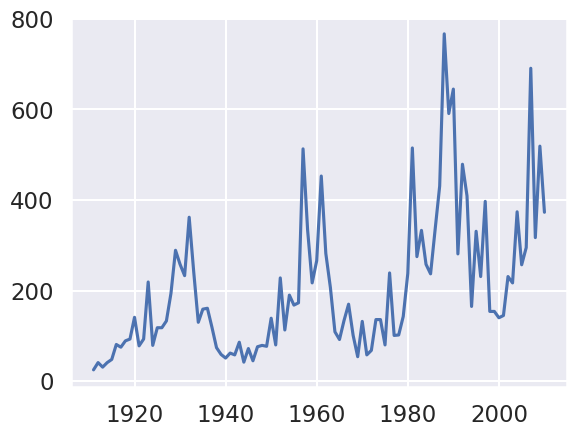

In [77]:
# 図示
plt.plot(df.time, df.y)

In [78]:
# データを辞書型に変換
data_dict = {
    'n_sample': len(df),
    'catch_y': df['catch_y'].tolist(),
    'y': df['y'].tolist(),
}

In [79]:
# stanファイルの作成
model = """
data {
  int n_sample;                  // サンプルサイズ
  array[n_sample] int catch_y;   // 捕獲数
  array[n_sample] int y;         // 観測値
}

parameters {
  real trend;                    // 個体数増加トレンド
  real coef_catch_y;           // 捕獲数がトレンドに与える影響
  real mu_zero;                // 状態の初期値
  vector[n_sample] mu;       // 状態の推定値
  vector[n_sample] mu_noise; // 観測誤差の入った状態の推定値
  real<lower=0> s_w;          // 過程誤差の分散
  real<lower=0> s_v;          // 観測誤差の分散
}

transformed parameters{
  array[n_sample] real delta;    // 捕獲の影響が入ったトレンド
  array[n_sample] real lambda;   // ポアソン分布の期待値

  for(i in 1:n_sample){
    delta[i] = trend - coef_catch_y * catch_y[i];
  }

  for(i in 1:n_sample){
    lambda[i] = exp(mu_noise[i]);
  }
}

model {
  // 状態の初期値から最初の時点の状態が得られる
  mu[1] ~ normal(mu_zero, sqrt(s_w));

  // 状態方程式に従い、状態が遷移する
  for (i in 2:n_sample){
    mu[i] ~ normal(mu[i - 1] + delta[i - 1], sqrt(s_w));
  }

  // 観測誤差が加わる
  for(i in 1:n_sample){
    mu_noise[i] ~ normal(mu[i], sqrt(s_v));
  }

  //  ポアソン分布に従って観測値が得られる
  for(i in 1:n_sample){
    y[i] ~ poisson(lambda[i]);
  }
}

generated quantities{
  array[n_sample] real lambda_smooth;     // 観測誤差の無い、個体数の期待値
  real best_catch_y;                        // 個体数の増減がない捕獲量

  for(i in 1:n_sample){
    lambda_smooth[i] = exp(mu[i]);
  }

  best_catch_y = trend / coef_catch_y;
}

"""

In [80]:
# stanファイルのビルド
stm = stan.build(model, data=data_dict, random_seed=1) # データはビルド時に指定

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [81]:
# モデルの推定
fit_stan_count = stm.sample(num_samples=8000,
                              num_chains=4
                            )

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.97 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_2prm9jfh/model_xvjqyljm.stan', line 42, column 4 to column 43)

In [82]:
# 結果の確認
result = fit_stan_count.to_frame()
data = pd.DataFrame()

data["trend"] = result["trend"]
data["coef_catch_y"] = result["coef_catch_y"]
data["best_catch_y"] = result["best_catch_y"]
data.describe().T

,count,mean,std,min,25%,50%,75%,max
trend,32000.0,0.107004,0.015428,0.025526,0.097367,0.106775,0.116484,0.208599
coef_catch_y,32000.0,0.009520,0.001201,0.003510,0.008742,0.009510,0.010280,0.017550
best_catch_y,32000.0,11.280737,1.262108,3.498587,10.519432,11.241707,11.998952,21.880750


In [83]:
# すべての推定結果の出力
pd.set_option("display.max_columns", 10000)
result.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,trend,coef_catch_y,mu_zero,mu.1,mu.2,mu.3,mu.4,mu.5,mu.6,mu.7,mu.8,mu.9,mu.10,mu.11,mu.12,mu.13,mu.14,mu.15,mu.16,mu.17,mu.18,mu.19,mu.20,mu.21,mu.22,mu.23,mu.24,mu.25,mu.26,mu.27,mu.28,mu.29,mu.30,mu.31,mu.32,mu.33,mu.34,mu.35,mu.36,mu.37,mu.38,mu.39,mu.40,mu.41,mu.42,mu.43,mu.44,mu.45,mu.46,mu.47,mu.48,mu.49,mu.50,mu.51,mu.52,mu.53,mu.54,mu.55,mu.56,mu.57,mu.58,mu.59,mu.60,mu.61,mu.62,mu.63,mu.64,mu.65,mu.66,mu.67,mu.68,mu.69,mu.70,mu.71,mu.72,mu.73,mu.74,mu.75,mu.76,mu.77,mu.78,mu.79,mu.80,mu.81,mu.82,mu.83,mu.84,mu.85,mu.86,mu.87,mu.88,mu.89,mu.90,mu.91,mu.92,mu.93,mu.94,mu.95,mu.96,mu.97,mu.98,mu.99,mu.100,mu_noise.1,mu_noise.2,mu_noise.3,mu_noise.4,mu_noise.5,mu_noise.6,mu_noise.7,mu_noise.8,mu_noise.9,mu_noise.10,mu_noise.11,mu_noise.12,mu_noise.13,mu_noise.14,mu_noise.15,mu_noise.16,mu_noise.17,mu_noise.18,mu_noise.19,mu_noise.20,mu_noise.21,mu_noise.22,mu_noise.23,mu_noise.24,mu_noise.25,mu_noise.26,mu_noise.27,mu_noise.28,mu_noise.29,mu_noise.30,mu_noise.31,mu_noise.32,mu_noise.33,mu_noise.34,mu_noise.35,mu_noise.36,mu_noise.37,mu_noise.38,mu_noise.39,mu_noise.40,mu_noise.41,mu_noise.42,mu_noise.43,mu_noise.44,mu_noise.45,mu_noise.46,mu_noise.47,mu_noise.48,mu_noise.49,mu_noise.50,mu_noise.51,mu_noise.52,mu_noise.53,mu_noise.54,mu_noise.55,mu_noise.56,mu_noise.57,mu_noise.58,mu_noise.59,mu_noise.60,mu_noise.61,mu_noise.62,mu_noise.63,mu_noise.64,mu_noise.65,mu_noise.66,mu_noise.67,mu_noise.68,mu_noise.69,mu_noise.70,mu_noise.71,mu_noise.72,mu_noise.73,mu_noise.74,mu_noise.75,mu_noise.76,mu_noise.77,mu_noise.78,mu_noise.79,mu_noise.80,mu_noise.81,mu_noise.82,mu_noise.83,mu_noise.84,mu_noise.85,mu_noise.86,mu_noise.87,mu_noise.88,mu_noise.89,mu_noise.90,mu_noise.91,mu_noise.92,mu_noise.93,mu_noise.94,mu_noise.95,mu_noise.96,mu_noise.97,mu_noise.98,mu_noise.99,mu_noise.100,s_w,s_v,delta.1,delta.2,delta.3,delta.4,delta.5,delta.6,delta.7,delta.8,delta.9,delta.10,delta.11,delta.12,delta.13,delta.14,delta.15,delta.16,delta.17,delta.18,delta.19,delta.20,delta.21,delta.22,delta.23,delta.24,delta.25,delta.26,delta.27,delta.28,delta.29,delta.30,delta.31,delta.32,delta.33,delta.34,delta.35,delta.36,delta.37,delta.38,delta.39,delta.40,delta.41,delta.42,delta.43,delta.44,delta.45,delta.46,delta.47,delta.48,delta.49,delta.50,delta.51,delta.52,delta.53,delta.54,delta.55,delta.56,delta.57,delta.58,delta.59,delta.60,delta.61,delta.62,delta.63,delta.64,delta.65,delta.66,delta.67,delta.68,delta.69,delta.70,delta.71,delta.72,delta.73,delta.74,delta.75,delta.76,delta.77,delta.78,delta.79,delta.80,delta.81,delta.82,delta.83,delta.84,delta.85,delta.86,delta.87,delta.88,delta.89,delta.90,delta.91,delta.92,delta.93,delta.94,delta.95,delta.96,delta.97,delta.98,delta.99,delta.100,lambda.1,lambda.2,lambda.3,lambda.4,lambda.5,lambda.6,lambda.7,lambda.8,lambda.9,lambda.10,lambda.11,lambda.12,lambda.13,lambda.14,lambda.15,lambda.16,lambda.17,lambda.18,lambda.19,lambda.20,lambda.21,lambda.22,lambda.23,lambda.24,lambda.25,lambda.26,lambda.27,lambda.28,lambda.29,lambda.30,lambda.31,lambda.32,lambda.33,lambda.34,lambda.35,lambda.36,lambda.37,lambda.38,lambda.39,lambda.40,lambda.41,lambda.42,lambda.43,lambda.44,lambda.45,lambda.46,lambda.47,lambda.48,lambda.49,lambda.50,lambda.51,lambda.52,lambda.53,lambda.54,lambda.55,lambda.56,lambda.57,lambda.58,lambda.59,lambda.60,lambda.61,lambda.62,lambda.63,lambda.64,lambda.65,lambda.66,lambda.67,lambda.68,lambda.69,lambda.70,lambda.71,lambda.72,lambda.73,lambda.74,lambda.75,lambda.76,lambda.77,lambda.78,lambda.79,lambda.80,lambda.81,lambda.82,lambda.83,lambda.84,lambda.85,lambda.86,lambda.87,lambda.88,lambda.89,lambda.90,lambda.91,lambda.92,lambda.93,lambda.94,lambda.95,lambda.96,lambda.97,lambda.98,lambda.99,lambda.100,lambda_smooth.1,lambda_smooth.2,lambda_smooth.3,lambda_smooth.4,lambda_smooth.5,lambda_smooth.6,lambda_smooth.7,lambda_smooth.8,lambda_smooth.9,lambda_smooth.10,lambda_smooth.11,lambda_smooth.12,lambda_smooth.1

In [84]:
# 観測誤差を取り除いた状態の、95%区間と中央値
sampling_result = az.from_pystan(fit_stan_count)

model_lambda_smooth = np.quantile(
    sampling_result.posterior["lambda_smooth"],
    q=[0.025, 0.5, 0.975],
    axis=(0, 1)
)

# データフレームに変換
df_columns = ["lwr", "fit", "upr"]
model_lambda_smooth_df = pd.DataFrame(model_lambda_smooth.T, columns=df_columns)

In [85]:
# データの整形
stan_df = pd.concat([
    pd.DataFrame({'y': df['y'], 'time': df['time']}),
    pd.DataFrame(model_lambda_smooth_df, columns=["lwr", "fit", "upr"])
], axis=1)

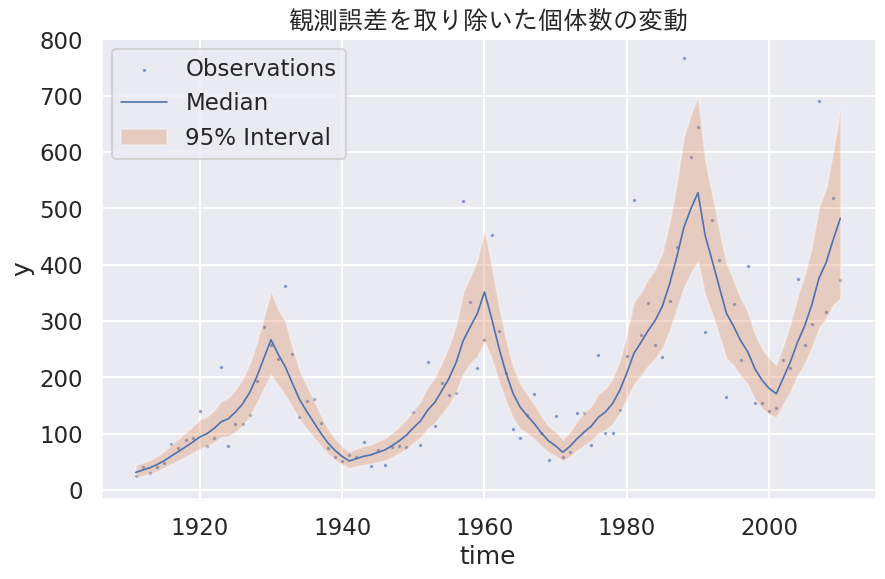

In [86]:
# 図示
plt.figure(figsize=(10, 6))
plt.title("観測誤差を取り除いた個体数の変動", fontname="IPAexGothic")
plt.scatter(stan_df['time'], stan_df['y'], alpha=0.6, s=0.9, label='Observations')
plt.plot(stan_df['time'], stan_df['fit'], label='Median', linewidth=1.2)
plt.fill_between(stan_df['time'], stan_df['lwr'], stan_df['upr'], alpha=0.3, label='95% Interval')

plt.xlabel('time')
plt.ylabel('y')
plt.legend()
plt.show()